In [1]:
from fastai import *
from fastai.vision import *
import tqdm

PATH = Path('../..').resolve()

seed = 12345

%matplotlib inline

In [2]:
sys.path.append(f'{PATH}/src')

from mxresnet import *
from ranger import Ranger



Mish activation loaded...
Mish activation loaded...


In [3]:
xGASS_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

tfms = get_transforms(
    do_flip=True,
    flip_vert=True,
    max_zoom=1.0,
    max_rotate=15.0,
    max_lighting=0,
    max_warp=0,
)

# Try using ALFALFA only

In [49]:
df = pd.read_csv(f"{PATH}/data/a40-SDSS_gas-frac.csv")

In [50]:
src = (
    ImageList.from_df(
        df, path=PATH, folder="images-legacy", suffix=".jpg", cols="AGCNr"
    )
    .split_by_rand_pct(0.2, seed=seed)
    .label_from_df(cols=["logfgas"], label_cls=FloatList)
)

data = (
    src.transform(tfms, size=224)
    .databunch(bs=32)
    .normalize(xGASS_stats)
)

In [51]:
model = mxresnet50()
model[-1] = nn.Linear(model[-1].in_features, 1, bias=True)

In [52]:
learn = Learner(
    data,
    model=model,
    opt_func=partial(Ranger),
    loss_func=root_mean_squared_error,
    wd=1e-3,
    bn_wd=False,
    true_wd=True,
)

In [53]:
learn.load('best_a40A-50');

set state called


# Load data set

## Note: some of these images are outside the SDSS footprint, so let's remove them on the basis of the images that are already downloaded.

In [63]:
nibles = pd.read_csv(f'{PATH}/data/NIBLES_clean.csv')

In [64]:
# only keep not dwarfs and not 
nibles = nibles[(nibles.logMstar > 8) & np.isfinite(nibles.logfgas) ].copy()

In [65]:
nible_ids = np.array([p.stem for p in list(PATH.glob(pattern='images-nibles_cleaned/*.jpg'))], dtype=int)

In [66]:
nibles.set_index('nibles_id', inplace=True)
nibles.drop([obj for obj in nibles.index if obj not in nible_ids], inplace=True)
nibles.reset_index(inplace=True)

## Check $z$ distributions

Text(0.5, 0, 'Redshift')

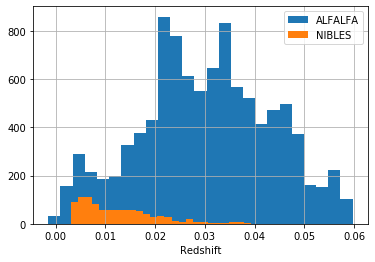

In [95]:
(pd.read_csv(f'{PATH}/data/a40.datafile3.csv').z_sdss).hist(bins=25, label='ALFALFA')
nibles.z.hist(bins=25, label='NIBLES')

plt.legend()
plt.xlabel('Redshift')

The NIBLES sample is honestly probably too low-redshift...

## Insert NIBLES as validation set and predict

In [ ]:
nibles_data = (
    ImageList.from_df(nibles, path=PATH, folder="images-nibles", suffix=".jpg", cols="nibles_id")
        .split_none()
        .label_from_df(cols=["logfgas"], label_cls=FloatList)
    .transform(tfms, size=224)
    .databunch(bs=128)
    .normalize(xGASS_stats)
)

In [ ]:
learn.data.valid_dl = nibles_data.train_dl

In [ ]:
learn.validate()

In [ ]:
learn.show_results()

Okay, quite a number of these don't even have optical counterparts (or are improperly centered)!

# Even more cleaned test sample

I went through and removed the following:
- images with no apparent optical source in the center (since those were likely to have faulty stellar mass estimates)
- images with only a point source in the center (only one or two, again these are likely mismatches)
- images corrupted by bleed from stars or flatfielding issues (only two)

Note that these do *not* include very low surface brightness galaxies; so long as they are detectable in imaging, I left them in.

Remaining: 942 / 1585 (59%)

In [96]:
nibles = pd.read_csv(f'{PATH}/data/NIBLES_clean.csv')
nibles = nibles[(nibles.logMstar > 8) & np.isfinite(nibles.logfgas)].copy()

In [97]:
nible_ids = np.array([p.stem for p in list(PATH.glob(pattern='images-nibles_cleaned/*.jpg'))], dtype=int)

In [98]:
nibles.set_index('nibles_id', inplace=True)
nibles.drop([obj for obj in nibles.index if obj not in nible_ids], inplace=True)
nibles.reset_index(inplace=True)

In [99]:
nibles_data = (
    ImageList.from_df(nibles, path=PATH, folder="images-nibles_cleaned", suffix=".jpg", cols="nibles_id")
        .split_none()
        .label_from_df(cols=["logfgas"], label_cls=FloatList)
    .transform(tfms, size=224)
    .databunch(bs=128)
    .normalize(xGASS_stats)
)

In [100]:
learn.data.valid_dl = nibles_data.train_dl

In [101]:
results = np.zeros((len(learn.data.valid_ds), 2))

for i, [x,y] in tqdm.tqdm(enumerate(learn.data.valid_ds), total=len(results)):
    p = learn.predict(x)[0]
    results[i] = [float(p.data[0]), float(y.data)]

100%|██████████| 942/942 [00:18<00:00, 49.73it/s]


In [102]:
results.shape

(942, 2)

In [111]:
rmse = ((results[:,0] - results[:,1])**2).mean()**0.5
rmse

0.3746461819485785

Text(0, 0.5, '$\\mathcal{M}_{\\rm pred}$')

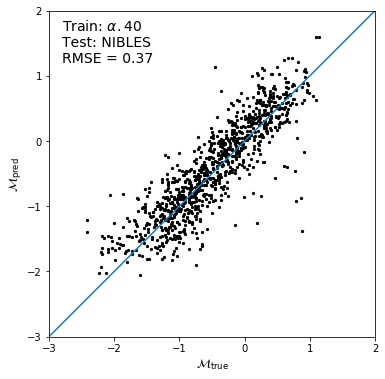

In [113]:
plt.figure(figsize=(6, 6))


plt.scatter(results[:,1], results[:,0], c='k', s=5)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-3, 2)
plt.ylim(-3, 2)

plt.text(-2.8, 1.2, r'Train: $\alpha.40$' + '\nTest: NIBLES' + f'\nRMSE = {rmse:.2f}', fontsize=14)
plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=12)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=12)

In [120]:
res_df = pd.DataFrame({'nibles_id': nibles.nibles_id, 'fgas_true': results[:,1], 'fgas_pred': results[:,0]})

In [121]:
res_df.to_csv(f'{PATH}/results/nibles/nibles_clean_results.csv', index=False)

## Compare results to quoted 45% overprediction between NIBLES & ALFALFA


In [114]:
recalibration = np.log10(1.45) # dex units

In [115]:
np.median(res_df.fgas_pred - res_df.fgas_true), recalibration

(0.0955057293176651, 0.16136800223497488)

In [116]:
((res_df.fgas_pred - (res_df.fgas_true + recalibration))**2).mean()**0.5

0.3769701519105141

In [117]:
res_df.sample(3)

nibles_id  fgas_true  fgas_pred
128        534       0.22   0.442290
672       1974      -0.86  -0.772912
701       2046      -0.27  -0.240647

## Examine most overpredicted

In [118]:
def load_image(idx, df, ax=None, annotate=True):
    """Helper function to load and annotate image"""
    
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        
    fgas_true, fgas_pred = df.iloc[idx]
    name = df.index[idx]
    
    # get image
    image = plt.imread(f'{PATH}/images-nibles_cleaned/{name}.jpg')
    ax.imshow(image)
    ax.axis('off')
    
    # label
    if annotate:
        fontdict = dict(color='white', size=18)
        ax.text(0.5, 0.9, f'NIBLES #{name}', fontdict=fontdict, transform=ax.transAxes, ha='center', va='bottom')
        ax.text(0.95, 0.125, r'$\mathcal{M}_{\rm true}$' + f' = {fgas_true: .3f}', fontdict=fontdict, transform=ax.transAxes, ha='right', va='bottom')
        ax.text(0.95, 0.025, r'$\mathcal{M}_{\rm pred}$' + f' = {fgas_pred: .3f}', fontdict=fontdict, transform=ax.transAxes, ha='right', va='bottom')

In [119]:
overestimated = res_df.iloc[np.argsort(res_df.fgas_true - res_df.fgas_pred)]
overestimated.set_index('nibles_id', inplace=True)

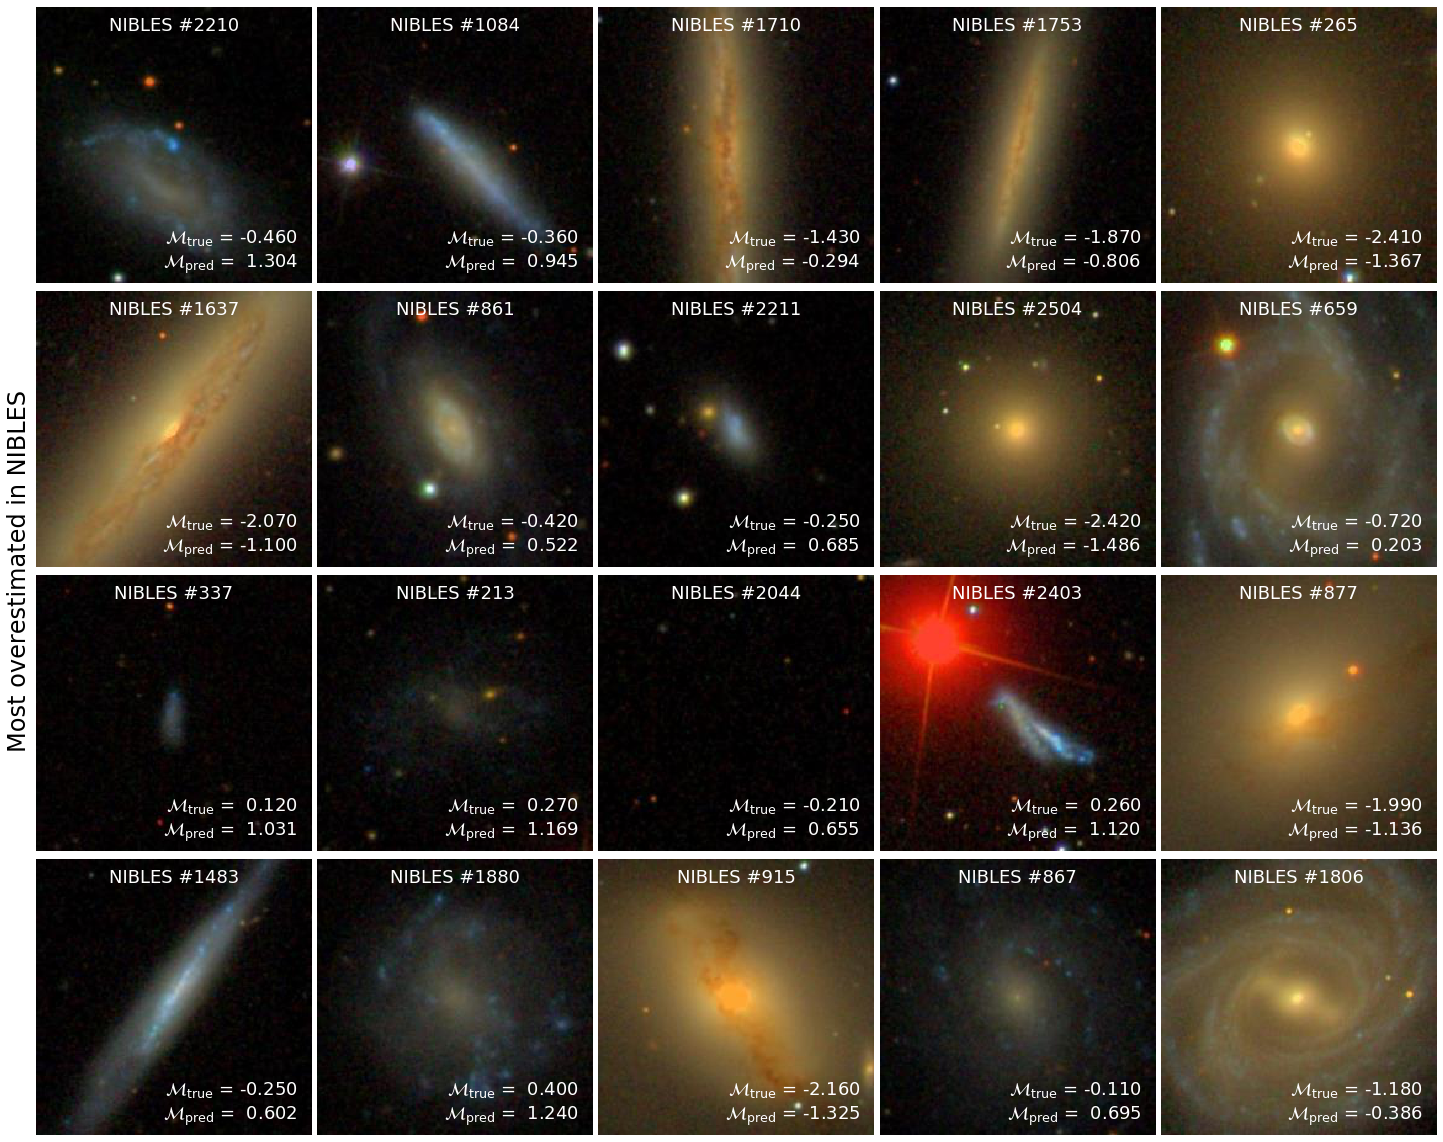

In [120]:
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
for idx in range(20):
    ax = axes.flat[idx]
    load_image(idx, overestimated, ax=ax)
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.02, hspace=0.02, left=0.02)
fig.text(0, 0.5, r'Most overestimated in NIBLES', rotation=90, fontsize=24, va='center');

Some of these are probably not legit, e.g., 2044 is clearly a blank field, and I went venture that most of the blue spirals in here are actually better estimated than in NIBLES.

## Most underpredicted

In [121]:
underestimated = res_df.iloc[np.argsort(res_df.fgas_pred - res_df.fgas_true )]
underestimated.set_index('nibles_id', inplace=True)

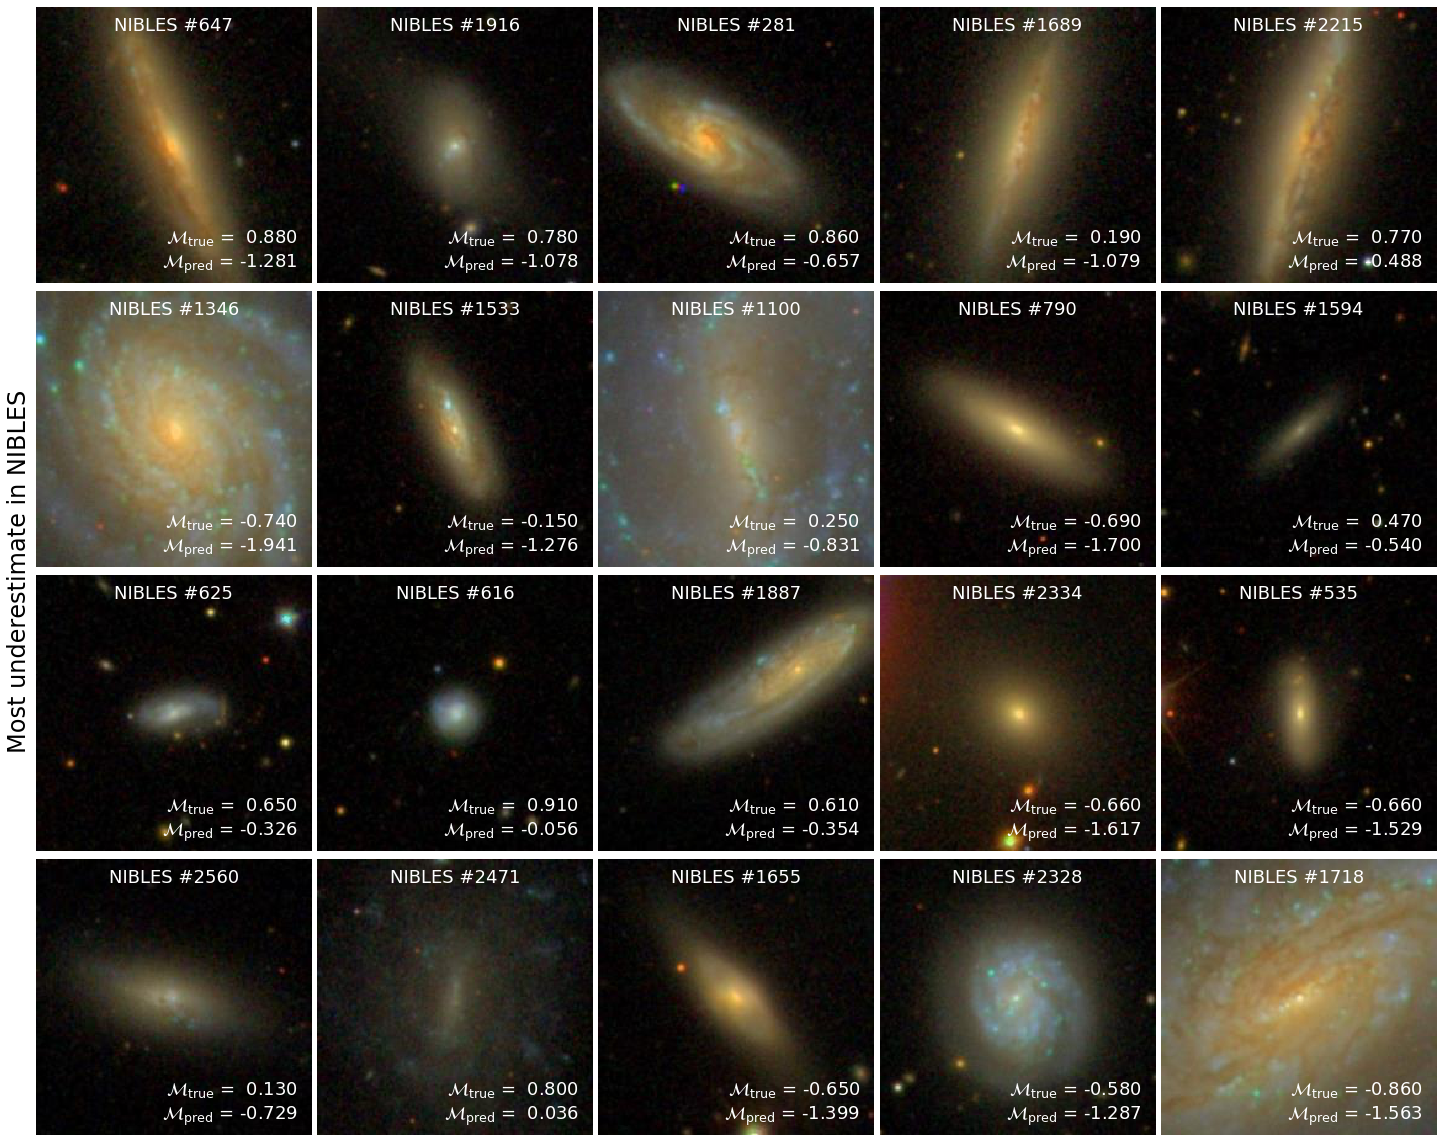

In [122]:
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
for idx in range(20):
    ax = axes.flat[idx]
    load_image(idx, underestimated, ax=ax)
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.02, hspace=0.02, left=0.02)
fig.text(0, 0.5, r'Most underestimate in NIBLES', rotation=90, fontsize=24, va='center');

Honestly, some of these feel suspicious to me too. Perhaps the dust is obscuring seriously gas-rich, star-forming regions... But in many of these, our CNN is underestimating HI mass because the galaxy is larger than the field of view.

# Repeat with combined xGASS + ALFALFA learner

In [123]:
learn.load('combined-mxresnet50-fc_80ep');

set state called


In [124]:
nibles = pd.read_csv(f'{PATH}/data/NIBLES_clean.csv')
nibles = nibles[(nibles.logMstar > 8) & np.isfinite(nibles.logfgas)].copy()

In [125]:
nible_ids = np.array([p.stem for p in list(PATH.glob(pattern='images-nibles_cleaned/*.jpg'))], dtype=int)

nibles.set_index('nibles_id', inplace=True)
nibles.drop([obj for obj in nibles.index if obj not in nible_ids], inplace=True)
nibles.reset_index(inplace=True)

In [126]:
nibles_data = (
    ImageList.from_df(nibles, path=PATH, folder="images-nibles_cleaned", suffix=".jpg", cols="nibles_id")
        .split_none()
        .label_from_df(cols=["logfgas"], label_cls=FloatList)
    .transform(tfms, size=224)
    .databunch(bs=128)
    .normalize(xGASS_stats)
)

In [127]:
learn.data.valid_dl = nibles_data.train_dl

In [128]:
results = np.zeros((len(learn.data.valid_ds), 2))

for i, [x,y] in tqdm.tqdm(enumerate(learn.data.valid_ds), total=len(results)):
    p = learn.predict(x)[0]
    results[i] = [float(p.data[0]), float(y.data)]

100%|██████████| 942/942 [00:19<00:00, 48.53it/s]


In [132]:
rmse = ((res_df.fgas_pred - (res_df.fgas_true))**2).mean()**0.5
rmse

0.37368604262994753

In [135]:
nmad = lambda x: 1.4826*np.median(np.abs(x - np.median(x)))

In [136]:
nmad(res_df.fgas_pred - res_df.fgas_true)

0.31373473768830296

Text(0, 0.5, '$\\mathcal{M}_{\\rm pred}$')

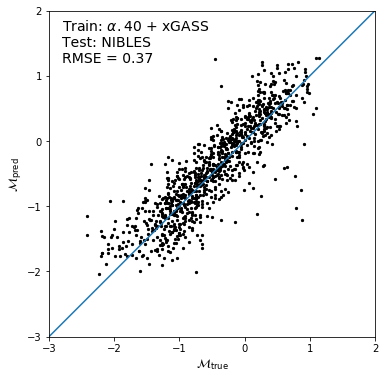

In [129]:
plt.figure(figsize=(6, 6))


plt.scatter(results[:,1], results[:,0], c='k', s=5)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-3, 2)
plt.ylim(-3, 2)

plt.text(-2.8, 1.2, r'Train: $\alpha.40$ + xGASS' + '\nTest: NIBLES' + f'\nRMSE = {rmse:.2f}', fontsize=14)
plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=12)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=12)

In [38]:
res_df = pd.DataFrame({'nibles_id': nibles.nibles_id, 'fgas_true': results[:,1], 'fgas_pred': results[:,0]})

In [39]:
res_df.to_csv(f'{PATH}/results/nibles/nibles_clean_combined-results.csv', index=False)

## Check results

In [130]:
np.median(res_df.fgas_pred - res_df.fgas_true), np.log10(1.45)

(0.0955057293176651, 0.16136800223497488)

In [131]:
((res_df.fgas_pred - (res_df.fgas_true))**2).mean()**0.5

0.37368604262994753

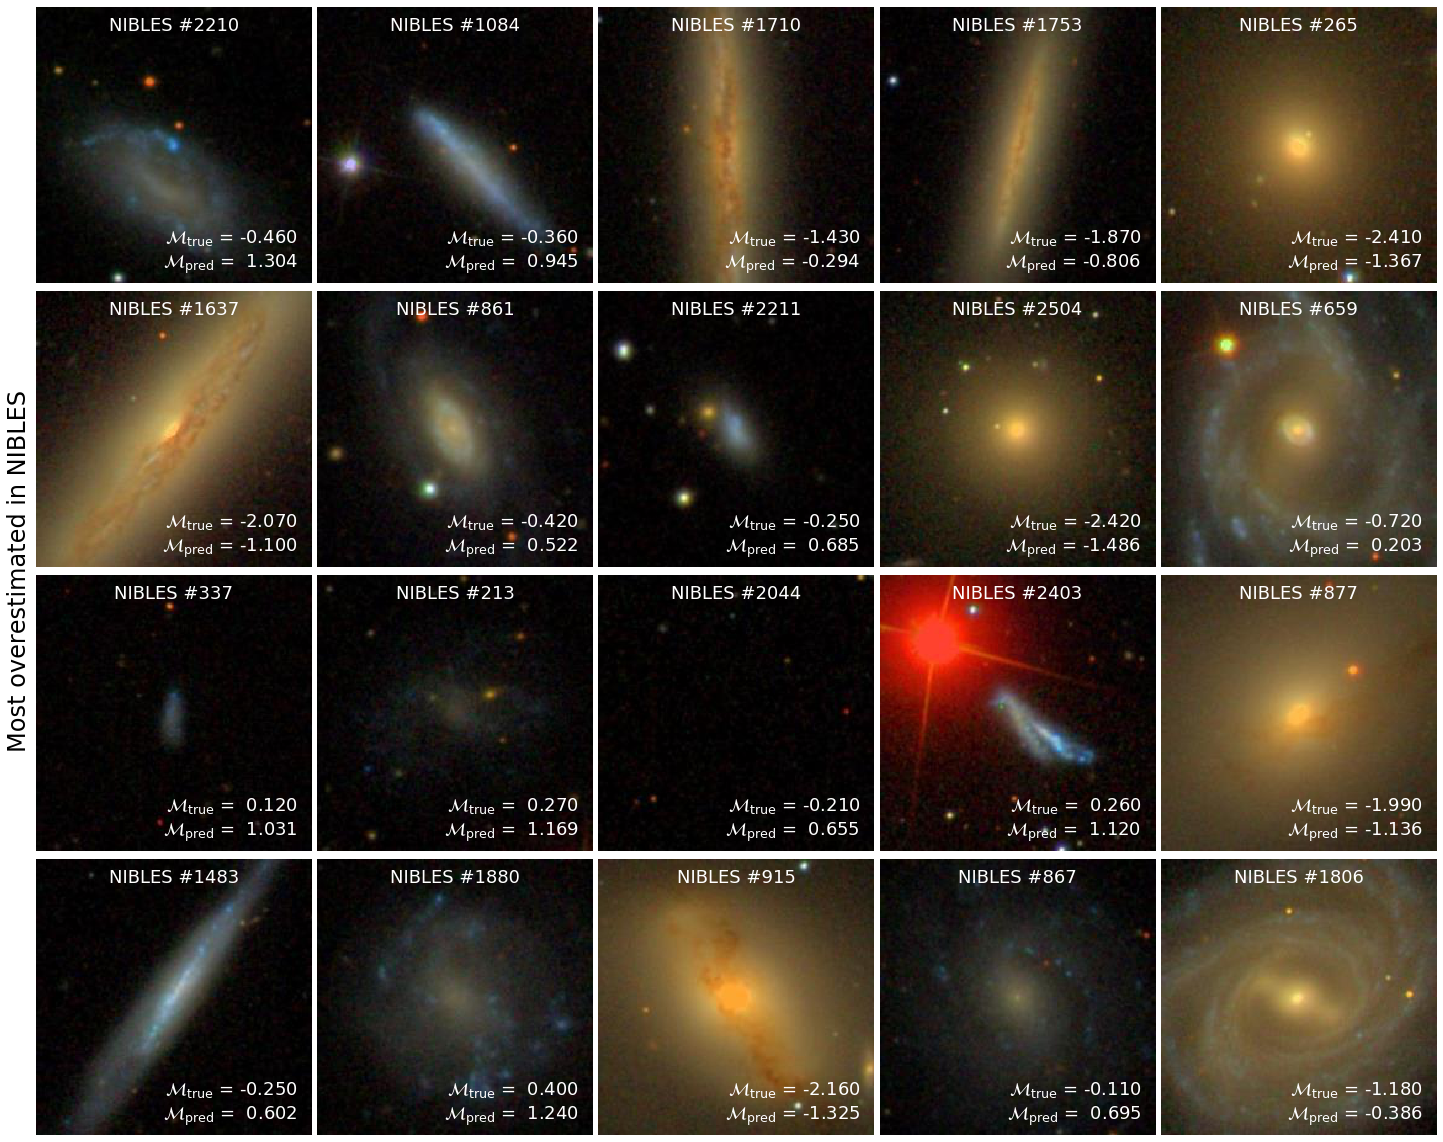

In [45]:
overestimated = res_df.iloc[np.argsort(res_df.fgas_true - res_df.fgas_pred)]
overestimated.set_index('nibles_id', inplace=True)

fig, axes = plt.subplots(4, 5, figsize=(20, 16))
for idx in range(20):
    ax = axes.flat[idx]
    load_image(idx, overestimated, ax=ax)
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.02, hspace=0.02, left=0.02)
fig.text(0, 0.5, r'Most overestimated in NIBLES', rotation=90, fontsize=24, va='center');

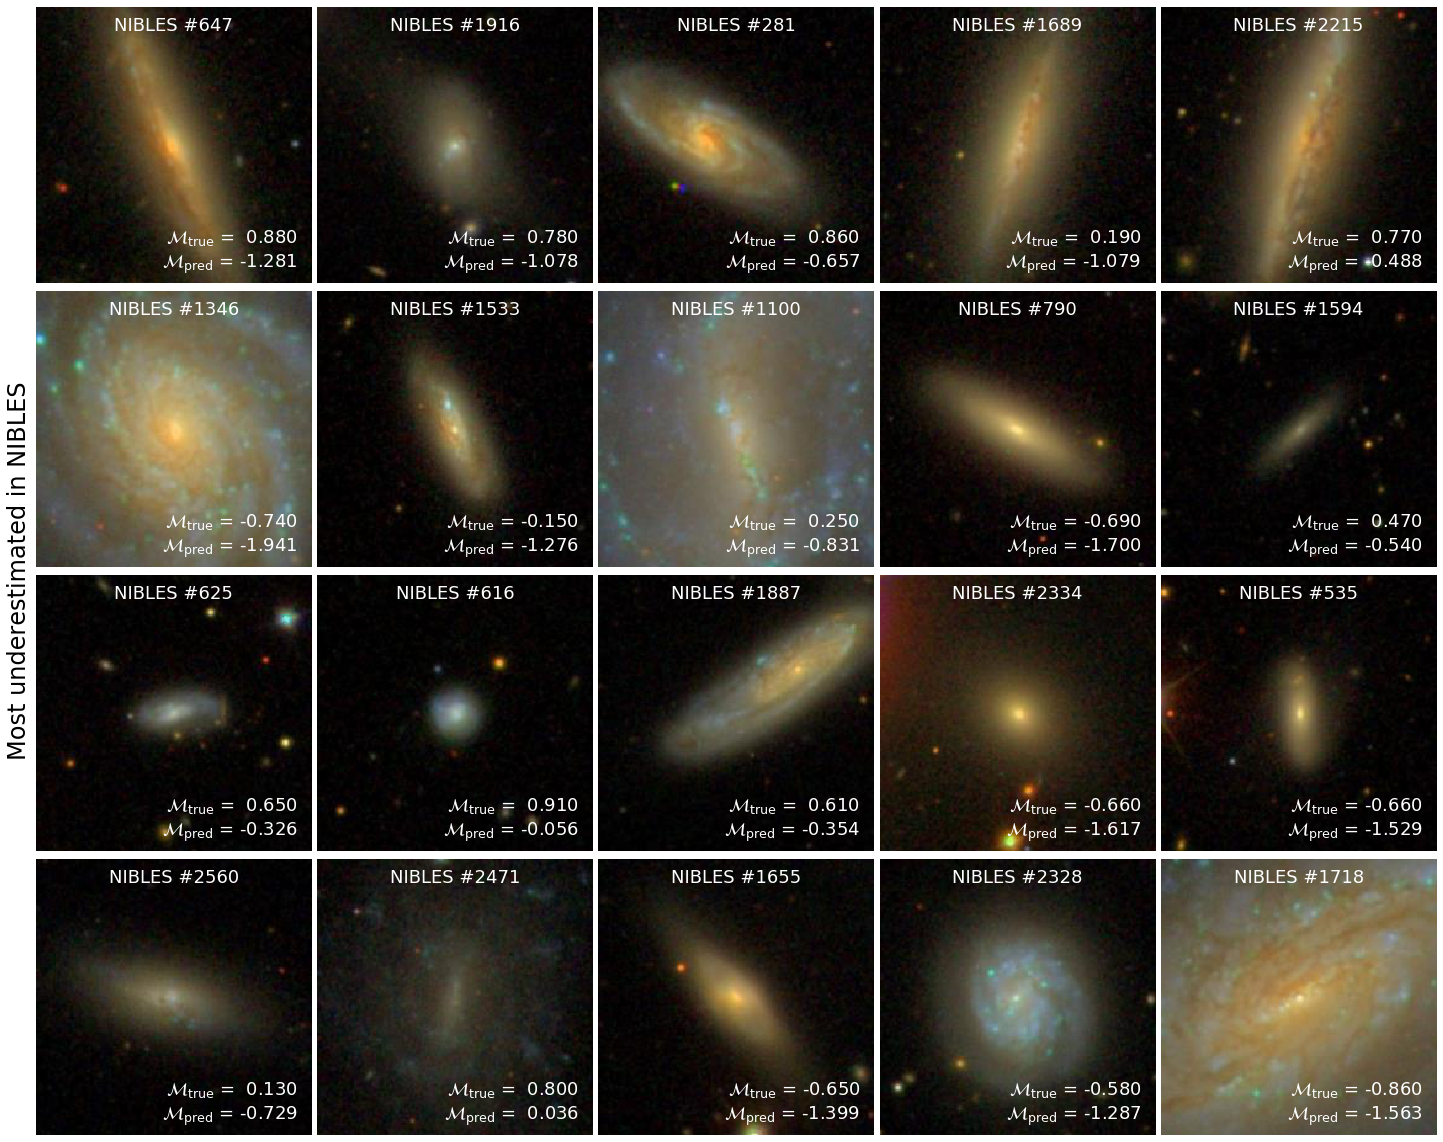

In [47]:
underestimated = res_df.iloc[np.argsort(res_df.fgas_pred - res_df.fgas_true )]
underestimated.set_index('nibles_id', inplace=True)

fig, axes = plt.subplots(4, 5, figsize=(20, 16))
for idx in range(20):
    ax = axes.flat[idx]
    load_image(idx, underestimated, ax=ax)
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.02, hspace=0.02, left=0.02)
fig.text(0, 0.5, r'Most underestimated in NIBLES', rotation=90, fontsize=24, va='center');